In [13]:
import torch
import torch.tensor as tensor
import gpytorch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import warnings
from IPython.core import debugger
import time
import ax
from ax.api import ParameterType, RangeParameter, SearchSpace
from ax.api import modelbridge
from botorch.utils.sampling import SobolEngine, NormalQMCEngine
from botorch.utils.sampling import draw_sobol_normal_samples

# Define a GP and specify hyperparameters

In [34]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [35]:
train_x = None
train_y = None
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
theta = model.state_dict()
print('Default hyperparameters (before softplus transformation):')
pprint(theta)
softplus_inv = lambda a: np.log(np.exp(a) - 1)
raw_noise_var = softplus_inv(0.0001)
print(nn.functional.softplus(tensor([raw_noise_var])))
raw_length_scale = softplus_inv(.5)
print('Set noise level and length scale:')
theta['likelihood.noise_covar.raw_noise'].data.fill_(raw_noise_var)
theta['covar_module.base_kernel.raw_lengthscale'].data.fill_(raw_length_scale)
pprint(theta)
print(model.covar_module.base_kernel.lengthscale.item())
print(model.likelihood.noise.item())

Default hyperparameters (before softplus transformation):
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([[0.]])),
             ('mean_module.constant', tensor([[0.]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]]))])
tensor([0.0001])
Set noise level and length scale:
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([[-9.2103]])),
             ('mean_module.constant', tensor([[0.]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.4328]]))])
0.5
0.00020000003860332072


# Draw a sample from the prior GP and posterior GP

tensor(0.3640)
tensor([-1.,  1.])
tensor([0.3640, 1.4767])


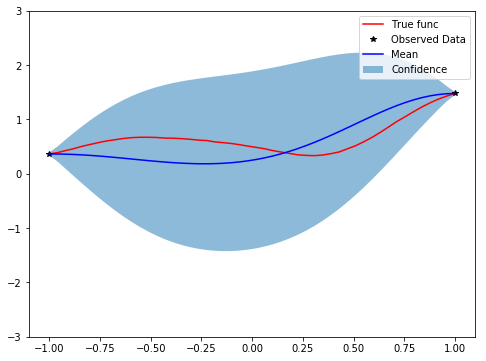

In [15]:
model.eval()
bound = 1
n = 50
x = torch.linspace(-bound,bound,n)

y_prior = model(x)
torch.manual_seed(13)
y = y_prior.sample()
print(y[0])

train_idx = [np.round(n/3), np.round(n*2/3)];
train_idx = [0, n-1]
train_x = x[train_idx]
train_y = y[train_idx]
y_best = torch.min(train_y)
print(train_x)
print(train_y)
model.set_train_data(train_x, train_y, strict=False)
y_post = model(x)

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'r')
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['True func', 'Observed Data', 'Mean', 'Confidence'])

# Define EI for minimization problem
EI(x) = sig * (z * Phi(z) +N(z)), where z = (y_best - mu(x)) / sig(x)

In [16]:

def check_bounds(x, bounds):
    """
    check if x falls into the bounded region
    x: 1*d
    bounds: d*2
    """
    d = bounds.shape[0]
    x = x.reshape(-1,1)
    assert x.shape[0] == d
    if (np.any(x < bounds[:,0]) or
        np.any(x > bounds[:,1])):
        return False
    return True 

In [40]:
def expected_improvement(mu, sig, y_best):
    z = (y_best - mu) / sig
    standard_normal = torch.distributions.normal.Normal(loc=0, scale=1)
    # g.cdf(z) * z + torch.exp(g.log_prob(z))
    ei = sig * (z * standard_normal.cdf(z) + torch.exp(standard_normal.log_prob(z)))
    return ei

def expected_improvement_wrapper(x, gp_model, y_best):
    y_dist = gp_model(x)
    sig = torch.sqrt(y_dist.variance)
    ei_values = expected_improvement(y_dist.mean, sig, y_best)
    return ei_values


def multi_start_optim(func, 
                      dim=None,
                      bounds=None,
                      num_iters=100, 
                      x_inits=None, 
                      learning_rate=0.01,  
                      num_restarts=1, 
                      tolerance=1e-8,
                      print_every = 10):
    # optimize ei continuously
    if x_inits is not None:
        num_restarts = len(x_inits)
    else:
        d = bounds.shape[0]
        sobol_engine = SobolEngine(d, scramble=True)
        x_inits = np.array(sobol_engine.draw(num_restarts), dtype=np.float32)
        lower_bound = bounds[:,0].reshape(1,-1)
        interval_length = (bounds[:,1] - bounds[:,0]).reshape(1,-1)
        x_inits = x_inits * interval_length + lower_bound
    print(x_inits)
    x_star = tensor(x_inits[0])
    min_loss = 0.
    for restart in range(num_restarts):   
        x0 = tensor(x_inits[restart], requires_grad=True)
        print('Restart at: ', x0)
        optimizer = optim.Adam([x0], lr=learning_rate)
        for i in range(num_iters):
            optimizer.zero_grad()
            loss = func(x0)
            loss.backward()

            def closure():
                optimizer.zero_grad()
                loss = func(x0)
                loss.backward()
                return loss
            optimizer.step(closure)
            if not check_bounds(x0.detach().numpy(), bounds):
                break
            
            if i % print_every == 0:
                #info = (f'iter {i:3}, EI value: {-loss.item():10.3} ' 
                #        f'x: {x0.item(): -10.3} x.grad: {x0.grad.item(): 10.3}')
                info = 'iter %3d: EI = %-10.10f x.grad.norm = %-10.10f' % (i, -loss.item(),
                                                                                x0.grad.norm())
                print(info)
            if x0.grad.norm() < tolerance:
                break
        if loss < min_loss:
            min_loss = loss
            x_star = x0
        print('local optimum:', x_star)
    return x_star, min_loss


# Plot EI and the optimized location, with multi-restart Adam optimizer

In [18]:
search_space = np.array([[-1., 1.]])
a = torch.linspace(-1,1,3)
print(a.dtype)
print(train_x.dtype)
print('%f' % (train_x.norm(),))

torch.float32
torch.float32
1.414214


max ei: tensor(0.4169, grad_fn=<MaxBackward1>)
optimal x: tensor(-0.1837)
Restart at:  tensor([0.3266], requires_grad=True)
iter   0: EI = 0.1976129562 x.grad.norm = 0.7303965092
iter  10: EI = 0.2684438825 x.grad.norm = 0.6751748323
iter  20: EI = 0.3287958205 x.grad.norm = 0.5539299250
iter  30: EI = 0.3723617196 x.grad.norm = 0.4048549235
iter  40: EI = 0.3983880281 x.grad.norm = 0.2628905475
iter  50: EI = 0.4109265506 x.grad.norm = 0.1492303759
iter  60: EI = 0.4155905843 x.grad.norm = 0.0702814087
iter  70: EI = 0.4167959392 x.grad.norm = 0.0227104947
iter  80: EI = 0.4169374704 x.grad.norm = 0.0011342391
iter  90: EI = 0.4169123769 x.grad.norm = 0.0095894672
local optimum: tensor([-0.1862], requires_grad=True)
Restart at:  tensor([0.1760], requires_grad=True)
iter   0: EI = 0.3013785481 x.grad.norm = 0.6185897589
iter  10: EI = 0.3556785583 x.grad.norm = 0.4705740511
iter  20: EI = 0.3917985260 x.grad.norm = 0.3058538437
iter  30: EI = 0.4099973142 x.grad.norm = 0.1604362130
ite

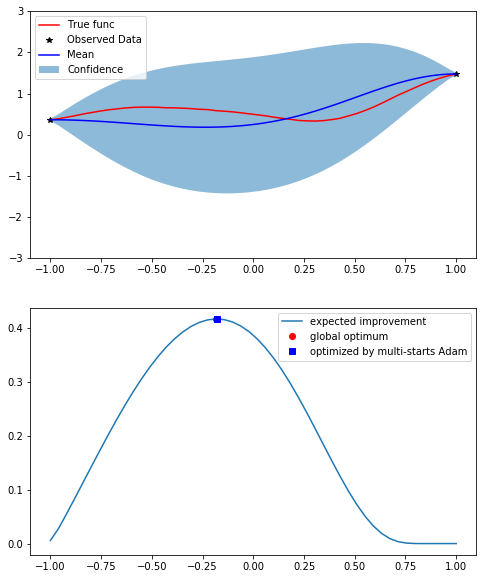

In [31]:
# test ei


ei = expected_improvement_wrapper(x, model, y_best)
print('max ei:', torch.max(ei))
print('optimal x:', x[torch.argmax(ei)])
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax[0].plot(x.numpy(), y.numpy(), 'r')
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax[0].plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax[0].set_ylim([-3, 3])
    ax[0].legend(['True func', 'Observed Data', 'Mean', 'Confidence'])
    ax[1].plot(x.numpy(), ei.detach().numpy(), label='expected improvement')
    ax[1].plot(x[torch.argmax(ei)].numpy(), torch.max(ei).numpy(), 'ro', label='global optimum')
    
num_iters = 100
learning_rate = 0.01
func = lambda x: -expected_improvement_wrapper(x, model, y_best)
bounds = np.array([[-bound, bound]])
x_star, max_ei = multi_start_optim(func, bounds=bounds, num_restarts=5)
print("optimized x:", x_star)
ax[1].plot(x_star.item(), -max_ei.item(), 'bs', label='optimized by multi-starts Adam')
ax[1].legend()

# Define q-EI using reparameterization and Monte Carlo sampling

In [20]:
# can also be defined in a class inheriting nn.Module
class qExpectedImprovement(nn.Module):
    
    def __init__(self, gp_model, y_current_best, 
                 num_mc_samples=1000, sampler='mc', seed=None):
        super(qExpectedImprovement, self).__init__()
        self.gp_model = gp_model
        self.y_current_best = y_current_best
        self.num_mc_samples = num_mc_samples
        self.z_samples = None
        self.seed = seed
        self.sampler = sampler
        
    def forward(self, x, z_samples=None, seed=None):
        """
        Args:
            x: tensor of shape (n, d)
        Returns:
            expected improvement of locations x
        """
        q = x.shape[0]
        f_preds = self.gp_model(x)
        f_mean = f_preds.mean.view(q, -1)
        f_covar = f_preds.covariance_matrix
        try:
            L = f_covar.cholesky()
        except: 
            f_covar = f_covar + torch.eye(q) * 1e-6
            L = f_covar.cholesky()
        if self.z_samples is None:  # only sample once, then reuse the samples
            if seed or self.seed is not None:
                torch.manual_seed(seed or self.seed)
            if self.sampler == 'mc':
                self.z_samples = torch.randn(q, self.num_mc_samples)
            elif self.sampler == 'qmc':
                self.z_samples = draw_sobol_normal_samples(q, self.num_mc_samples).transpose(0,1)
        #debugger.set_trace()
        y = f_mean + L @ self.z_samples
        y_min, _ = torch.min(y, 0)
        ei = torch.relu(self.y_current_best - y_min)  

        return ei.mean()
    
    def set_seed(self, seed=0):
        self.seed = seed
        self.z_sample = None
        
    def two_ei_monte_carlo(self, mu, Sigma, y_current_best, num_mc_samples):
        two_d_normal = MultivariateNormal(loc=mu.reshape(torch.Size([2])), 
                                          covariance_matrix=Sigma)
        joint_samples = two_d_normal.sample((num_mc_samples,))
        y_min, _ = torch.min(joint_samples, dim=1)
        improvement = torch.relu(y_current_best -  y_min)
        value = torch.mean(improvement)
        return value
    
    def two_ei_analytic(self, mu, Sigma, y_current_best):
        """
        qEI with q=2, analytic solution
        reference: Ginsbourger et al. (2010), Kriging Is Well-Suited to Parallelize Optimization. 
        https://pdfs.semanticscholar.org/787e/e940ff557f0dcf8d07e9c7ade39d00d5e3df.pdf
        Notations and math follow page 11-14 of the paper
        """
        
        standard_normal = Normal(loc=0, scale=1)
        normpdf = lambda x: torch.exp(standard_normal.log_prob(x))
        normcdf = lambda x: standard_normal.cdf(x)
        
        epsilon = lambda gamma1, alpha1, beta1: (
            alpha1 * 
            normpdf(torch.sqrt(beta1**2/(1+alpha1**2))) /
            torch.sqrt(1+alpha1**2)*
            normcdf(torch.sqrt(1 + alpha1**2)*
                    (gamma1 + alpha1 * beta1 / (1+alpha1**2))) 
            -
            normpdf(gamma1) *
            normcdf(alpha1*gamma1 + beta1)
        )
        
        def delta(m1, m2, sig1, sig2, c12):
            M1 = np.array([m1, m2-m1])
            Gamma = np.array(
                [[sig1**2,       c12 - sig1**2],
                 [c12 - sig1**2, sig2**2 + sig1**2 - 2*c12]]) 
            from scipy.stats import multivariate_normal as mvn
            dist = mvn(mean=M1, cov=Gamma)
            return dist.cdf(np.array([y_current_best,0.]))
        
        def B(i):
            # i=0, j=1 or i=1, j=0
            j = 1 - i
            sig1 = torch.sqrt(Sigma[i,i])  
            sig2 = torch.sqrt(Sigma[j,j])
            m1 = mu[i]
            m2 = mu[j]
            c12 = Sigma[i,j]  # covariance
            rho = c12 / (sig1 * sig2)  # correlation coefficient
            gamma1 = (y_current_best - m1) / sig1
            sqrt_one_minus_rho2 = torch.sqrt(1 - rho.pow(2))
            beta1 = (m1 - m2)/(sig2 * sqrt_one_minus_rho2)
            alpha1 = (sig1 - rho * sig2)/(sig2 * sqrt_one_minus_rho2)
            
            two_ei_value = ((m1 - y_current_best) * delta(m1, m2, sig1, sig2, c12) +
                            sig1 * epsilon(gamma1, alpha1, beta1))
            return two_ei_value
        
        def ei_plus_B(i):
            j = 1 - i
            ei = expected_improvement(mu[i], torch.sqrt(Sigma[i,i]), y_current_best)
            return ei + B(i)
        
        return ei_plus_B(0) + ei_plus_B(1)

        
    def compute_2ei_surface(self, x, analytic=True, use_forward=False, compute_diag_with_ei=True):
        num_points = x.shape[0]
        f_preds = self.gp_model(x)
        f_mean = f_preds.mean.view(num_points, -1)
        f_covar = f_preds.covariance_matrix
        two_ei_surface = np.full((num_points, num_points), fill_value=np.nan)
        
        if analytic:
            two_ei_func = lambda mu, Sigma: self.two_ei_analytic(mu, Sigma, 
                                                                 self.y_current_best)
        else:
            two_ei_func = lambda mu, Sigma: self.two_ei_monte_carlo(mu, Sigma, 
                                                                    self.y_current_best,
                                                                    self.num_mc_samples)

        for first in range(num_points):
            for second in range(first + compute_diag_with_ei, num_points):
                
                idx = [first, second]
                mu = f_mean[idx]
                Sigma = f_covar[idx][:,idx]
                try:
                    if not use_forward:
                        two_ei_surface[first, second] = two_ei_func(mu, Sigma)
                    else:
                        two_ei_surface[first, second] = self.forward(x[idx].reshape(torch.Size([2,1])))
                except:
                    warnings.warn('covariance matrix singular')
                    Sigma += torch.eye(2) * 1e-6
                    two_ei_surface[first, second] = two_ei_func(mu, Sigma)
                    
                two_ei_surface[second, first] = two_ei_surface[first, second]
            if compute_diag_with_ei:
                sig = torch.sqrt(f_covar[first, first])
                two_ei_surface[first, first] = expected_improvement(f_mean[first], 
                                                                    sig, 
                                                                    self.y_current_best)
        return two_ei_surface
    


# Plot the 2-EI surface to see if the Monte Carlo approx matches with analytic solution

tensor(0.3640)
(20, 20)
(20, 20)


/home/shalijiang/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:209: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


(20, 20)
100000
[[0.00569242 0.07530917]
 [0.07530917 0.07315958]]
[[0.00569242 0.0761326 ]
 [0.0761326  0.07315958]]
[[0.00569242 0.07579889]
 [0.07579889 0.07315958]]
[0.00569242 0.07315958]
Mean absolute error: 0.0006247862250149376


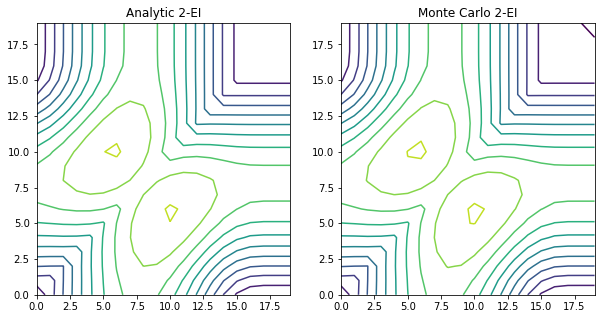

In [21]:
print(y_best)

num_mc_samples = 100000
qEI = qExpectedImprovement(model, y_best, num_mc_samples)
test_x = torch.linspace(-bound, bound, 20)
compute_diag_with_ei = True
two_ei_surface = qEI.compute_2ei_surface(test_x, analytic=False, 
                                         compute_diag_with_ei=compute_diag_with_ei)
print(two_ei_surface.shape)

two_ei_surface1 = qEI.compute_2ei_surface(test_x, analytic=True, 
                                          compute_diag_with_ei=compute_diag_with_ei)
print(two_ei_surface1.shape)

two_ei_surface2 = qEI.compute_2ei_surface(test_x, analytic=False, use_forward=True, 
                                          compute_diag_with_ei=compute_diag_with_ei)
print(two_ei_surface2.shape)
qEI = qExpectedImprovement(model, y_best, num_mc_samples, sampler='qmc')
two_ei_surface3 = qEI.compute_2ei_surface(test_x, analytic=False, use_forward=True, 
                                          compute_diag_with_ei=compute_diag_with_ei)
print(two_ei_surface3.shape)

f, ax = plt.subplots(1, 3, figsize=(15, 5))
#ax[0].contour(two_ei_surface, 10)
#ax[0].title('monte carlo comput
ax[0].contour(two_ei_surface1, 10)
ax[0].set_title('Analytic 2-EI')
ax[1].contour(two_ei_surface2, 10)
ax[1].set_title('Monte Carlo 2-EI')
ax[1].contour(two_ei_surface2, 10)
ax[1].set_title('Quasi Monte Carlo 2-EI')

print(qEI.num_mc_samples)
print_num = 2
print(two_ei_surface[:print_num,:print_num])
print(two_ei_surface2[:print_num,:print_num])
print(two_ei_surface1[:print_num,:print_num])
ei_test_x = expected_improvement_wrapper(test_x, model, y_best)
print(ei_test_x[:print_num].detach().numpy())
print('Mean absolute error:', np.mean(np.abs(two_ei_surface1 - two_ei_surface2)))


# See how the error changes with the number of samples

In [22]:
exp_num = np.arange(10, 20)
num_mc_samples_to_try = 2**exp_num
len_num_mc_samples = len(num_mc_samples_to_try)
num_repeats = 5
abs_error = np.zeros((num_repeats, len_num_mc_samples, 2))
times = np.zeros((num_repeats, len_num_mc_samples, 2))
test_x = torch.linspace(-bound, bound, 20)
compute_diag_with_ei = False

for i in range(len_num_mc_samples):
    
    num_mc_samples = num_mc_samples_to_try[i]
    
    two_ei_surface1 = qEI.compute_2ei_surface(test_x, analytic=True, 
                                              compute_diag_with_ei=compute_diag_with_ei)
    for repeat in range(num_repeats):
        
        qEI = qExpectedImprovement(model, y_best, num_mc_samples, sampler='mc', seed=repeat)
        #qEI.set_seed(repeat)
        start = time.time()
        two_ei_surface2 = qEI.compute_2ei_surface(test_x, analytic=False, use_forward=True, 
                                                  compute_diag_with_ei=compute_diag_with_ei)
        end = time.time()
        times[repeat, i, 0] = end - start
        abs_error[repeat, i, 0] = np.mean(np.abs(two_ei_surface1 - two_ei_surface2))
        
        
        qEI = qExpectedImprovement(model, y_best, num_mc_samples, sampler='qmc', seed=repeat)
        #qEI.set_seed(repeat)
        start = time.time()
        two_ei_surface3 = qEI.compute_2ei_surface(test_x, analytic=False, use_forward=True, 
                                                  compute_diag_with_ei=compute_diag_with_ei)
        end = time.time()
        times[repeat, i, 1] = end - start
        abs_error[repeat, i, 1] = np.mean(np.abs(two_ei_surface1 - two_ei_surface3))
    print('Number of samples %-10d Mean absolute error: %f %f' % (num_mc_samples, 
                                                               np.mean(abs_error[:,i,0], axis=0),
                                                               np.mean(abs_error[:,i,1], axis=0)))

/home/shalijiang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: covariance matrix singular


Number of samples 1024       Mean absolute error: 0.013862 0.000336
Number of samples 2048       Mean absolute error: 0.010348 0.000075
Number of samples 4096       Mean absolute error: 0.005297 0.000068
Number of samples 8192       Mean absolute error: 0.002743 0.000027
Number of samples 16384      Mean absolute error: 0.002358 0.000022
Number of samples 32768      Mean absolute error: 0.002169 0.000009
Number of samples 65536      Mean absolute error: 0.001824 0.000008
Number of samples 131072     Mean absolute error: 0.001202 0.000005
Number of samples 262144     Mean absolute error: 0.000725 0.000005
Number of samples 524288     Mean absolute error: 0.000414 0.000005


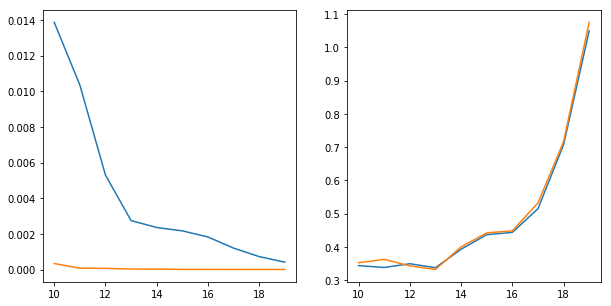

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(exp_num, (abs_error.mean(axis=0)))
ax[1].plot(exp_num, times.mean(axis=0))


# Optimize 2-EI surface with optim

In [25]:
num_iters = 2000
learning_rate = 0.001
num_mc_samples = 10000

optimized_x = {}
max_eis = {}
max_q = 10
for q in range(2,max_q+1):
    print('q =', q)
    num_restarts = 2*q
    bounds = np.array([[-bound, bound] for _ in range(q)] )
    qEI = qExpectedImprovement(model, y_best, num_mc_samples, sampler='qmc')
    func = lambda x: -qEI(x)
    qx_star, max_ei = multi_start_optim(func, bounds=bounds, 
                                   num_restarts=num_restarts, 
                                   learning_rate=learning_rate, 
                                   num_iters=num_iters,
                                   print_every=num_iters/5)
    
    print("x star:", qx_star)
    print('max ei:', -max_ei)
    optimized_x[q] = qx_star
    max_eis[q] = max_ei


q = 2
Restart at:  tensor([0.3736, 0.2964], requires_grad=True)
iter   0: EI = 0.2206482887 x.grad.norm = 0.7434121966
iter 400: EI = 0.4361739755 x.grad.norm = 0.4135564268
iter 800: EI = 0.4944924712 x.grad.norm = 0.1467269659
iter 1200: EI = 0.5029553771 x.grad.norm = 0.0399073176
iter 1600: EI = 0.5036591887 x.grad.norm = 0.0077634035
local optimum: tensor([ 0.0509, -0.3931], requires_grad=True)
Restart at:  tensor([0.2227, 0.5633], requires_grad=True)
iter   0: EI = 0.2722332180 x.grad.norm = 0.6812808514
iter 400: EI = 0.4596321285 x.grad.norm = 0.3275286853
iter 800: EI = 0.4993566275 x.grad.norm = 0.0975641236
iter 1200: EI = 0.5034434795 x.grad.norm = 0.0208454467
iter 1600: EI = 0.5036522150 x.grad.norm = 0.0027365887
local optimum: tensor([ 0.0509, -0.3931], requires_grad=True)
Restart at:  tensor([0.6535, 0.1832], requires_grad=True)
iter   0: EI = 0.2971566021 x.grad.norm = 0.6310655475
iter 400: EI = 0.4694176316 x.grad.norm = 0.2807070613
iter 800: EI = 0.5011870861 x.gr

local optimum: tensor([ 0.4471, -0.1132,  1.0006,  0.1698,  0.5437], requires_grad=True)
Restart at:  tensor([0.1503, 0.3553, 0.4616, 0.3881, 0.0205], requires_grad=True)
iter   0: EI = 0.4039932787 x.grad.norm = 0.5436006188
iter 400: EI = 0.5260282755 x.grad.norm = 0.2014447898
iter 800: EI = 0.5495746732 x.grad.norm = 0.0712268129
iter 1200: EI = 0.5537579656 x.grad.norm = 0.0267453175
iter 1600: EI = 0.5545760989 x.grad.norm = 0.0106505537
local optimum: tensor([-0.3837, -0.1669,  0.2625,  0.0433, -0.6240], requires_grad=True)
Restart at:  tensor([0.0902, 0.8671, 0.8562, 0.8597, 0.9275], requires_grad=True)
iter   0: EI = 0.3492631614 x.grad.norm = 0.4926235676
iter 400: EI = 0.4162894487 x.grad.norm = 0.0486243069
iter 800: EI = 0.4169360697 x.grad.norm = 0.0006834436
iter 1200: EI = 0.4169361293 x.grad.norm = 0.0000009295
iter 1600: EI = 0.4169361889 x.grad.norm = 0.0000005383
local optimum: tensor([-0.3837, -0.1669,  0.2625,  0.0433, -0.6240], requires_grad=True)
Restart at:  te

iter 400: EI = 0.5290136337 x.grad.norm = 0.1759573966
iter 800: EI = 0.5532067418 x.grad.norm = 0.0641614422
iter 1200: EI = 0.5579711795 x.grad.norm = 0.0256543588
iter 1600: EI = 0.5590438843 x.grad.norm = 0.0115160076
local optimum: tensor([ 0.1035, -0.0802, -0.6599,  0.2953, -0.4489, -0.2627],
       requires_grad=True)
Restart at:  tensor([0.6419, 0.8217, 0.9932, 0.4224, 0.8697, 0.4743], requires_grad=True)
iter   0: EI = 0.1287681311 x.grad.norm = 0.6950428486
local optimum: tensor([ 0.1035, -0.0802, -0.6599,  0.2953, -0.4489, -0.2627],
       requires_grad=True)
x star: tensor([ 0.1035, -0.0802, -0.6599,  0.2953, -0.4489, -0.2627],
       requires_grad=True)
max ei: tensor(0.5593, grad_fn=<NegBackward>)
q = 7
Restart at:  tensor([0.2096, 0.6287, 0.3899, 0.2420, 0.1028, 0.4932, 0.8652],
       requires_grad=True)
iter   0: EI = 0.3565084338 x.grad.norm = 0.6270040870
iter 400: EI = 0.5090503097 x.grad.norm = 0.2736285031
iter 800: EI = 0.5452488065 x.grad.norm = 0.1049728394
ite

iter 400: EI = 0.4509672225 x.grad.norm = 0.4414866567
iter 800: EI = 0.5280148387 x.grad.norm = 0.2001465410
iter 1200: EI = 0.5473396778 x.grad.norm = 0.0883495212
iter 1600: EI = 0.5526353717 x.grad.norm = 0.0408333801
local optimum: tensor([ 0.1577, -0.0022,  0.3294, -0.6689, -0.4870, -0.3232, -0.1627,  0.9925],
       requires_grad=True)
Restart at:  tensor([0.5237, 0.1572, 0.0674, 0.1340, 0.9395, 0.7165, 0.3119, 0.2445],
       requires_grad=True)
iter   0: EI = 0.3782526255 x.grad.norm = 0.5960599780
local optimum: tensor([ 0.1577, -0.0022,  0.3294, -0.6689, -0.4870, -0.3232, -0.1627,  0.9925],
       requires_grad=True)
Restart at:  tensor([0.9960, 0.9318, 0.4992, 0.6436, 0.5086, 0.0385, 0.1482, 0.7116],
       requires_grad=True)
iter   0: EI = 0.3900214732 x.grad.norm = 0.5650327206
local optimum: tensor([ 0.1577, -0.0022,  0.3294, -0.6689, -0.4870, -0.3232, -0.1627,  0.9925],
       requires_grad=True)
Restart at:  tensor([0.1981, 0.2927, 0.6932, 0.3589, 0.2332, 0.9186, 0.59

local optimum: tensor([ 0.1971, -0.6929, -0.0534, -0.1748, -0.5401,  0.3491, -0.2942,  0.0675,
        -0.4142], requires_grad=True)
Restart at:  tensor([0.6237, 0.6561, 0.8423, 0.0481, 0.2143, 0.5253, 0.3323, 0.0910, 0.6404],
       requires_grad=True)
iter   0: EI = 0.3894411027 x.grad.norm = 0.5796820521
iter 400: EI = 0.5214519501 x.grad.norm = 0.2313743830
iter 800: EI = 0.5486758351 x.grad.norm = 0.0848087668
local optimum: tensor([ 0.1971, -0.6929, -0.0534, -0.1748, -0.5401,  0.3491, -0.2942,  0.0675,
        -0.4142], requires_grad=True)
Restart at:  tensor([0.8707, 0.2049, 0.6917, 0.7767, 0.2593, 0.0880, 0.0872, 0.8232, 0.1647],
       requires_grad=True)
iter   0: EI = 0.3645921946 x.grad.norm = 0.5444123149
iter 400: EI = 0.5134985447 x.grad.norm = 0.2617354393
iter 800: EI = 0.5480152369 x.grad.norm = 0.1009282619
iter 1200: EI = 0.5557783246 x.grad.norm = 0.0423017405
iter 1600: EI = 0.5575973392 x.grad.norm = 0.0178884640
local optimum: tensor([ 0.1971, -0.6929, -0.0534, 

iter 1600: EI = 0.5654359460 x.grad.norm = 0.0187960286
local optimum: tensor([-0.1953,  0.3629, -0.5546, -0.7010,  0.0174, -0.3147,  0.2364, -0.4329,
         0.1231, -0.0873], requires_grad=True)
Restart at:  tensor([0.1774, 0.7232, 0.8145, 0.4839, 0.4251, 0.0201, 0.2010, 0.4225, 0.5451,
        0.4990], requires_grad=True)
iter   0: EI = 0.4037629068 x.grad.norm = 0.5325866938
iter 400: EI = 0.5286091566 x.grad.norm = 0.2065284252
iter 800: EI = 0.5561564565 x.grad.norm = 0.0798861757
iter 1200: EI = 0.5625856519 x.grad.norm = 0.0363228582
iter 1600: EI = 0.5643859506 x.grad.norm = 0.0167480819
local optimum: tensor([-0.1953,  0.3629, -0.5546, -0.7010,  0.0174, -0.3147,  0.2364, -0.4329,
         0.1231, -0.0873], requires_grad=True)
Restart at:  tensor([0.9362, 0.2010, 0.3855, 0.7394, 0.8160, 0.7382, 0.7578, 0.5134, 0.0669,
        0.9261], requires_grad=True)
iter   0: EI = 0.3777804673 x.grad.norm = 0.5848221779
iter 400: EI = 0.5149394274 x.grad.norm = 0.2361373156
local optimum

In [ ]:
bounds.shape

optimized x: tensor([-0.1811], requires_grad=True)


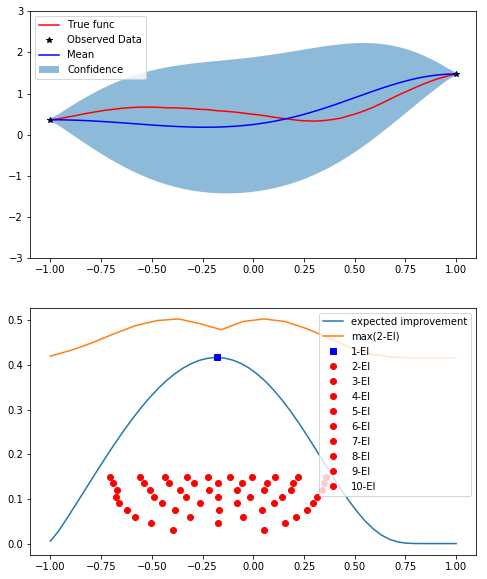

In [33]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax[0].plot(x.numpy(), y.numpy(), 'r')
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax[0].plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax[0].set_ylim([-3, 3])
    ax[0].legend(['True func', 'Observed Data', 'Mean', 'Confidence'])
    ax[1].plot(x.numpy(), ei.detach().numpy(), label='expected improvement')
    #ax[1].plot(x[torch.argmax(ei)].numpy(), torch.max(ei).numpy(), 'ro', label='global optimum')
    ax[1].plot(test_x.numpy(), two_ei_surface2.max(axis=0), label='max(2-EI)')    

print("optimized x:", x_star)
ax[1].plot(x_star.item(), -max_ei.item(), 'bs', label='1-EI')

for q in range(2, max_q+1):
    label = '%d-EI' % q
    ax[1].plot(optimized_x[q].detach().numpy(), np.zeros((q,))+q*.015, 'ro', label=label)

ax[1].legend()

# when EI is multi-modal

Default hyperparameters (before softplus transformation):
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([[0.]])),
             ('mean_module.constant', tensor([[0.]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]]))])
tensor([0.0001])
Set noise level and length scale:
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([[-9.2103]])),
             ('mean_module.constant', tensor([[0.]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.2587]]))])
0.25
0.00020000003860332072
tensor(0.3640)
tensor([-0.5102,  0.0204,  0.5510])
tensor([0.3471, 0.0892, 1.9655])
max ei: tensor(0.3468, grad_fn=<MaxBackward1>)
optimal x: tensor(-1.)
[[-0.37571764]
 [-0.9696909 ]
 [ 0.5202732 ]
 [ 0.9061153 ]]
Restart at:  tensor([-0.3757], requires_grad=True)
iter   0: EI = 0.0790582597 x.grad.norm = 1.0758610964
iter  20: EI = 0.2

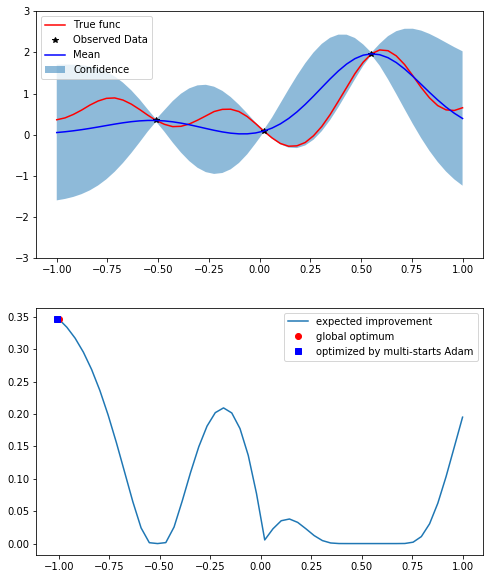

In [44]:
train_x = None
train_y = None
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
theta = model.state_dict()
print('Default hyperparameters (before softplus transformation):')
pprint(theta)
softplus_inv = lambda a: np.log(np.exp(a) - 1)
raw_noise_var = softplus_inv(0.0001)
print(nn.functional.softplus(tensor([raw_noise_var])))
raw_length_scale = softplus_inv(.25)
print('Set noise level and length scale:')
theta['likelihood.noise_covar.raw_noise'].data.fill_(raw_noise_var)
theta['covar_module.base_kernel.raw_lengthscale'].data.fill_(raw_length_scale)
pprint(theta)
print(model.covar_module.base_kernel.lengthscale.item())
print(model.likelihood.noise.item())

model.eval()
bound = 1
n = 50
x = torch.linspace(-bound,bound,n)

y_prior = model(x)
torch.manual_seed(13)
y = y_prior.sample()
print(y[0])

train_idx = [np.round(n/4),np.round(n/2), np.round(n*3/4)];
train_x = x[train_idx]
train_y = y[train_idx]
y_best = torch.min(train_y)
print(train_x)
print(train_y)
model.set_train_data(train_x, train_y, strict=False)
y_post = model(x)

ei = expected_improvement_wrapper(x, model, y_best)
print('max ei:', torch.max(ei))
print('optimal x:', x[torch.argmax(ei)])
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax[0].plot(x.numpy(), y.numpy(), 'r')
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax[0].plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax[0].set_ylim([-3, 3])
    ax[0].legend(['True func', 'Observed Data', 'Mean', 'Confidence'])
    ax[1].plot(x.numpy(), ei.detach().numpy(), label='expected improvement')
    ax[1].plot(x[torch.argmax(ei)].numpy(), torch.max(ei).numpy(), 'ro', label='global optimum')
    
num_iters = 100
learning_rate = 0.01
func = lambda x: -expected_improvement_wrapper(x, model, y_best)
bounds = np.array([[-bound, bound]], dtype=np.float32)
num_restarts = 4
x_star, max_ei = multi_start_optim(func, bounds=bounds, 
                                   num_restarts=num_restarts, 
                                   num_iters=num_iters,
                                   print_every=num_iters/5)
print("optimized x:", x_star)
ax[1].plot(x_star.item(), -max_ei.item(), 'bs', label='optimized by multi-starts Adam')
ax[1].legend()

In [46]:
num_iters = 2000
learning_rate = 0.001
num_mc_samples = 10000

optimized_x2 = {}
max_eis2 = {}
max_q = 10
for q in range(2,max_q+1):
    print('q =', q)
    num_restarts = 2*q
    bounds = np.array([[-bound, bound] for _ in range(q)], dtype=np.float32)
    qEI = qExpectedImprovement(model, y_best, num_mc_samples, sampler='qmc')
    func = lambda x: -qEI(x)
    qx_star, max_ei = multi_start_optim(func, bounds=bounds, 
                                   num_restarts=num_restarts, 
                                   learning_rate=learning_rate, 
                                   num_iters=num_iters,
                                   print_every=num_iters/5)
    
    print("x star:", qx_star)
    print('max ei:', -max_ei)
    optimized_x2[q] = qx_star
    max_eis2[q] = max_ei

q = 2
[[-0.9099158   0.82245743]
 [-0.43770772 -0.22946978]
 [ 0.34319377  0.26048815]
 [ 0.10957003 -0.39535254]]
Restart at:  tensor([-0.9099,  0.8225], requires_grad=True)
iter   0: EI = 0.3270526826 x.grad.norm = 0.5945886374
local optimum: tensor([-1.0002,  0.9390], requires_grad=True)
Restart at:  tensor([-0.4377, -0.2295], requires_grad=True)
iter   0: EI = 0.2004084289 x.grad.norm = 0.3967306912
iter 400: EI = 0.2276792228 x.grad.norm = 0.0000044540
iter 800: EI = 0.2276791930 x.grad.norm = 0.0000001192
iter 1200: EI = 0.2276791930 x.grad.norm = 0.0000001192
iter 1600: EI = 0.2276791930 x.grad.norm = 0.0000003576
local optimum: tensor([-1.0002,  0.9390], requires_grad=True)
Restart at:  tensor([0.3432, 0.2605], requires_grad=True)
iter   0: EI = 0.0134653812 x.grad.norm = 0.2432919741
iter 400: EI = 0.0425937660 x.grad.norm = 0.0016864177
iter 800: EI = 0.0425948165 x.grad.norm = 0.0000027418
local optimum: tensor([-1.0002,  0.9390], requires_grad=True)
Restart at:  tensor([ 0.

local optimum: tensor([-1.0000, -0.2554,  0.1399, -0.1796, -0.0911], requires_grad=True)
Restart at:  tensor([-0.1551,  0.3449,  0.2376, -0.7210,  0.5991], requires_grad=True)
iter   0: EI = 0.3523625135 x.grad.norm = 0.9221986532
iter 400: EI = 0.5065900683 x.grad.norm = 0.1831398606
local optimum: tensor([-1.0000, -0.2554,  0.1399, -0.1796, -0.0911], requires_grad=True)
Restart at:  tensor([-0.8187, -0.8417,  0.8212,  0.3565,  0.0046], requires_grad=True)
iter   0: EI = 0.3092287481 x.grad.norm = 1.4443473816
local optimum: tensor([-0.7977, -0.9774,  1.0003,  0.1683, -0.1269], requires_grad=True)
x star: tensor([-0.7977, -0.9774,  1.0003,  0.1683, -0.1269], requires_grad=True)
max ei: tensor(0.6135, grad_fn=<NegBackward>)
q = 6
[[ 0.60046375 -0.22513682  0.5376755   0.9268441   0.99396324  0.3200302 ]
 [ 0.12957692  0.24625099  0.07675874 -0.94158226  0.27989423 -0.3734532 ]
 [-0.80976415 -0.8871036  -0.03954339  0.2667755  -0.48358887  0.78534925]
 [-0.5195533   0.29900968  0.853164

local optimum: tensor([-0.1620, -0.0846,  1.0007, -0.2833,  0.1441, -0.2193, -0.9041],
       requires_grad=True)
Restart at:  tensor([-0.8536,  0.4957, -0.8984,  0.6382,  0.9152,  0.0950, -0.8036],
       requires_grad=True)
iter   0: EI = 0.4094783068 x.grad.norm = 1.0729259253
local optimum: tensor([-0.1620, -0.0846,  1.0007, -0.2833,  0.1441, -0.2193, -0.9041],
       requires_grad=True)
Restart at:  tensor([ 0.6746, -0.1427,  0.3416, -0.3151, -0.6392, -0.7071,  0.2258],
       requires_grad=True)
iter   0: EI = 0.3530285060 x.grad.norm = 0.9198441505
local optimum: tensor([-0.1620, -0.0846,  1.0007, -0.2833,  0.1441, -0.2193, -0.9041],
       requires_grad=True)
Restart at:  tensor([ 0.4412,  0.5057,  0.9389,  0.0789, -0.1285,  0.7169,  0.8726],
       requires_grad=True)
iter   0: EI = 0.3089839816 x.grad.norm = 1.0087054968
local optimum: tensor([-0.1620, -0.0846,  1.0007, -0.2833,  0.1441, -0.2193, -0.9041],
       requires_grad=True)
Restart at:  tensor([-0.0264, -0.8557, -0.2

local optimum: tensor([ 0.4312, -0.4805, -0.8660,  0.1485, -0.7886, -0.5819, -0.7080, -0.2770,
         1.0002], requires_grad=True)
Restart at:  tensor([ 0.9230,  0.1688, -0.2179, -0.0129, -0.4405,  0.8940, -0.4629,  0.6812,
        -0.2026], requires_grad=True)
iter   0: EI = 0.3245235980 x.grad.norm = 0.8633019328
local optimum: tensor([ 0.4312, -0.4805, -0.8660,  0.1485, -0.7886, -0.5819, -0.7080, -0.2770,
         1.0002], requires_grad=True)
Restart at:  tensor([-0.9034, -0.5055,  0.4623,  0.6064,  0.4914, -0.3689,  0.7512, -0.9566,
         0.0552], requires_grad=True)
iter   0: EI = 0.4251042902 x.grad.norm = 1.0983113050
local optimum: tensor([ 0.4312, -0.4805, -0.8660,  0.1485, -0.7886, -0.5819, -0.7080, -0.2770,
         1.0002], requires_grad=True)
Restart at:  tensor([-0.6420,  0.4189, -0.9467, -0.9971, -0.2162, -0.1730,  0.3473, -0.1499,
        -0.5925], requires_grad=True)
iter   0: EI = 0.5290299058 x.grad.norm = 0.7261816859
local optimum: tensor([ 0.4312, -0.4805, -0

local optimum: tensor([-0.2303,  0.5898, -0.3360, -0.0511,  0.0975,  1.0006,  0.7125, -0.1502,
        -0.5070,  0.6994], requires_grad=True)
Restart at:  tensor([-0.9253, -0.8501, -0.7208, -0.2638,  0.7845, -0.0326,  0.0342,  0.5166,
         0.8542,  0.1796], requires_grad=True)
iter   0: EI = 0.5272176862 x.grad.norm = 0.7776109576
local optimum: tensor([-1.0008, -0.8673, -0.7518, -0.2178,  0.8233, -0.0947,  0.0843,  0.5671,
         0.9383,  0.1660], requires_grad=True)
Restart at:  tensor([ 0.7898,  0.4709,  0.3530,  0.9564, -0.1312,  0.0561, -0.2206, -0.9574,
        -0.0121, -0.6428], requires_grad=True)
iter   0: EI = 0.5759662390 x.grad.norm = 0.7084559798
local optimum: tensor([ 0.7574,  0.4404,  0.3060,  1.0002, -0.1652,  0.0971, -0.2429, -1.0009,
        -0.0562, -0.6880], requires_grad=True)
Restart at:  tensor([ 0.7073, -0.6989, -0.2055, -0.9933,  0.6445,  0.3933, -0.8889, -0.3836,
         0.2467,  0.3331], requires_grad=True)
iter   0: EI = 0.5466729999 x.grad.norm = 0.

optimized x: tensor([-1.0095], requires_grad=True)


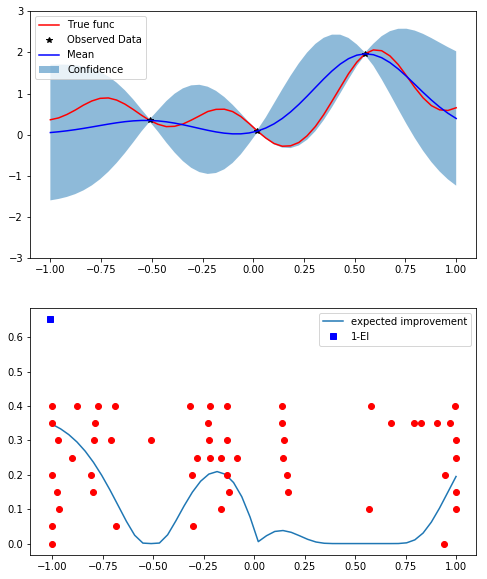

In [51]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax[0].plot(x.numpy(), y.numpy(), 'r')
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax[0].plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax[0].set_ylim([-3, 3])
    ax[0].legend(['True func', 'Observed Data', 'Mean', 'Confidence'])
    ax[1].plot(x.numpy(), ei.detach().numpy(), label='expected improvement')
  

print("optimized x:", x_star)
ax[1].plot(x_star.item(), -max_ei.item(), 'bs', label='1-EI')

for q in range(2, max_q+1):
    label = '%d-EI' % q
    ax[1].plot(optimized_x2[q].detach().numpy(), np.zeros((q,))+q*.05-.1, 'ro')

ax[1].legend()